# Wikipedia Album Detail Embedding

Experiment to see if vectors extracted from album details of Wikipedia have useful clustering.

The grouping obtained on album details do not seem that powerful. It looks to me like artist pages have more descriptions about style and influence than album detail pages.

Album detail pages may be good for finding specific features though such as sales.

TODO:
1. Reword code to use pre-downloaded and processed text.
2. Use doc2vec instead
3. Look for common patterns to extract between this and album text processing.


In [24]:
%run ./wikipedia_setup.ipynb

## Configure DB and Load Album Extract

In [3]:
db = sqlite3.Connection("var/data/music.db")

In [4]:
url_cache = URLContentCacheSqlite(db)

wayl_db = WikipediaAlbumYearListsDB(db)
albums = wayl_db.get_all()

### Get Albums With Detail Links

In [5]:
def get_album_link(links):
    if links is not None and 'Album' in links and len(links['Album']) > 0:
        return links['Album'][0]['href']
    
albums['AlbumLink'] = albums.Links.apply(get_album_link)

In [6]:
albums_w_detail_links = albums[albums.AlbumLink.notnull()]

## Build Document Word Lists

In [7]:
ad_word_retriever = AlbumDetailWPDocWordsRetriever(url_cache, db)

In [8]:
ad_word_retriever.process_albums(albums)

[2021-10-29 17:32:36.988026] Processed 1000 albums.
[2021-10-29 17:32:37.762060] Processed 2000 albums.
[2021-10-29 17:32:38.761409] Processed 3000 albums.
[2021-10-29 17:32:39.886563] Processed 4000 albums.
[2021-10-29 17:32:41.034631] Processed 5000 albums.
[2021-10-29 17:32:42.136149] Processed 6000 albums.
[2021-10-29 17:32:43.317392] Processed 7000 albums.
[2021-10-29 17:32:44.517049] Processed 8000 albums.
[2021-10-29 17:32:45.775496] Processed 9000 albums.
[2021-10-29 17:32:47.039913] Processed 10000 albums.
[2021-10-29 17:32:48.261692] Processed 11000 albums.
[2021-10-29 17:32:49.407100] Processed 12000 albums.
[2021-10-29 17:32:50.498895] Processed 13000 albums.
[2021-10-29 17:32:51.652778] Processed 14000 albums.
[2021-10-29 17:32:52.682040] Processed 15000 albums.
[2021-10-29 17:32:53.775152] Processed 16000 albums.
[2021-10-29 17:32:54.847178] Processed 17000 albums.
[2021-10-29 17:32:55.937898] Processed 18000 albums.
[2021-10-29 17:32:57.010253] Processed 19000 albums.
[2

In [9]:
pd.read_sql("select avg(length(words)), max(length(words)), sum(length(words)) from document_words", db)

,avg(length(words)),max(length(words)),sum(length(words))
0,13678.496174,257213,452197405


In [10]:
pd.read_sql("select * from document_words limit 5", db)

,category,doc_id,words
0,wp_album_year_list_detail,0,"[""mamaru"", ""album"", ""wikipedia"", ""mamaru"", ""al..."
1,wp_album_year_list_detail,1,[]
2,wp_album_year_list_detail,2,[]
3,wp_album_year_list_detail,3,"[""night"", ""call"", ""album"", ""wikipedia"", ""night..."
4,wp_album_year_list_detail,4,[]


## Build Up Word Counts

In [11]:
class WordCounter:
    
    def __init__(self):
        self.word_counts = {}
        self.doc_counts = {}
        self.doc_count = 0
    
    def add_doc(self, doc_words):
        w_counts = WordCounter.count_words(words)
        for w, c in w_counts.items():
            self.word_counts[w] = self.word_counts.get(w, 0) + c
            self.doc_counts[w] = self.doc_counts.get(w, 0) + 1
        self.doc_count += 1
    
    def get_word_info(self):
        word_info = pd.merge(
            pd.DataFrame({'Word': self.word_counts.keys(), 'WordCount': self.word_counts.values() }),
            pd.DataFrame({'Word': self.doc_counts.keys(), 'DocCount': self.doc_counts.values() }),
            on = 'Word'
        )
        word_info['WordPercent'] = 100.0 * word_info['WordCount'] / word_info['WordCount'].sum()
        word_info['DocPercent'] = 100.0 * word_info['DocCount'] / self.doc_count
        word_info['IDF'] = np.log(self.doc_count / (word_info['DocCount'] + 1))
        word_info = word_info.sort_values(by='WordCount', ascending=False).reset_index(drop=True)
        return word_info

    @staticmethod
    def count_words(words):
        wc = {}
        for w in words:
            wc[w] = wc.get(w, 0) + 1
        return wc

In [12]:
c = db.cursor()
c.execute(f"""
    select cast(doc_id as int), words
    from document_words
    where category = 'wp_album_year_list_detail'
""")

counter = WordCounter()

for row in c:
    doc_id = row[0]
    words = json.loads(row[1])
    counter.add_doc(words)

c.close()

In [13]:
word_info = counter.get_word_info()
word_info

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
0,the,2270997,29593,4.733235,89.515714,0.110722
1,of,819337,29593,1.707670,89.515714,0.110722
2,and,738930,29592,1.540085,89.512689,0.110756
3,album,644503,29558,1.343280,89.409843,0.111906
4,in,642121,29592,1.338315,89.512689,0.110756
...,...,...,...,...,...,...
357452,created—for,1,1,0.000002,0.003025,9.712902
357453,slowbeat,1,1,0.000002,0.003025,9.712902
357454,moonscapes,1,1,0.000002,0.003025,9.712902
357455,post-ambient,1,1,0.000002,0.003025,9.712902


In [14]:
word_info.WordCount.describe().astype(int).to_frame()

,WordCount
count,357457
mean,134
std,5480
min,1
25%,1
50%,2
75%,6
max,2270997


In [15]:
word_info.DocCount.describe().astype(int).to_frame()

,DocCount
count,357457
mean,50
std,745
min,1
25%,1
50%,1
75%,4
max,29593


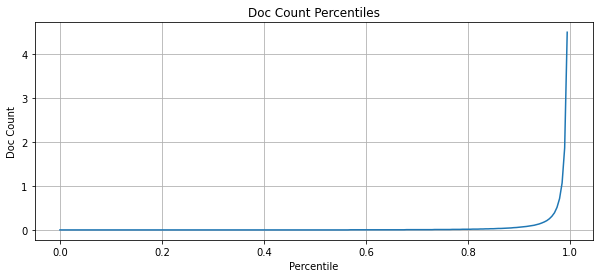

In [16]:
percentiles = np.arange(0.0, 1.0, 0.005)
percentile_values = word_info.DocPercent.quantile(percentiles)

plt.figure(figsize=(10, 4))
plt.title("Doc Count Percentiles")
plt.xlabel("Percentile")
plt.ylabel("Doc Count")
plt.plot(percentiles, percentile_values)
plt.grid(1)
plt.show()

In [17]:
word_info[word_info.Word.isin({'jazz', 'electronic', 'hop', 'hip', 'metal', 'experimental', 'nirvana', 'metallica', 'chains'})]

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
289,metal,28288,5411,0.058958,16.367706,1.809675
513,jazz,13540,3295,0.028220,9.967029,2.305584
582,hop,11584,3955,0.024143,11.963459,2.123060
583,hip,11565,3963,0.024104,11.987658,2.121040
835,electronic,7327,2917,0.015271,8.823618,2.427395
1758,experimental,2782,1723,0.005798,5.211894,2.953647
1931,metallica,2484,481,0.005177,1.454974,4.228105
2804,nirvana,1536,471,0.003201,1.424725,4.249070
2828,chains,1521,427,0.003170,1.291630,4.346926


In [18]:
key_words = word_info[
    (word_info.DocPercent <= 25) &
    (word_info.DocPercent >= 2)
].sort_values(by='DocPercent', ascending=False).reset_index(drop=True)

In [19]:
key_words

,Word,WordCount,DocCount,WordPercent,DocPercent,IDF
0,both,15184,8256,0.031647,24.973532,1.387233
1,black,29960,8244,0.062443,24.937233,1.388687
2,industry,24632,8236,0.051338,24.913034,1.389658
3,very,15358,8235,0.032009,24.910009,1.389779
4,again,17844,8219,0.037191,24.861611,1.391724
...,...,...,...,...,...,...
3043,congas,843,662,0.001757,2.002480,3.909274
3044,thrash,1489,662,0.003103,2.002480,3.909274
3045,husband,1029,662,0.002145,2.002480,3.909274
3046,sammy,1882,662,0.003922,2.002480,3.909274


In [20]:
def get_tf(words):
    wc = {}
    for w in words:
        wc[w] = wc.get(w, 0) + 1
    return { w: c / len(words) for w, c in wc.items() }

def get_tf_idf(words, key_words):
    tf = get_tf(words)
    return scipy.sparse.csr.csr_matrix((key_words.Word.apply(tf.get) * key_words.IDF).fillna(0.0))

In [21]:
tfidfs = []
for _, album in albums.iterrows():
    a_words = ad_word_retriever.get_words(album.name, album.AlbumLink)
    a_tfidf = get_tf_idf(a_words, key_words)
    tfidfs.append(a_tfidf)
    if (len(tfidfs) % 1000) == 0:
        print(f"[{dt.datetime.now()}] Computed tf/idf of {len(tfidfs)} docs.")

[2021-10-29 17:34:43.976065] Computed tf/idf of 1000 docs.
[2021-10-29 17:34:50.322433] Computed tf/idf of 2000 docs.
[2021-10-29 17:34:56.668984] Computed tf/idf of 3000 docs.
[2021-10-29 17:35:02.617002] Computed tf/idf of 4000 docs.
[2021-10-29 17:35:08.417220] Computed tf/idf of 5000 docs.
[2021-10-29 17:35:14.481462] Computed tf/idf of 6000 docs.
[2021-10-29 17:35:20.686633] Computed tf/idf of 7000 docs.
[2021-10-29 17:35:27.329510] Computed tf/idf of 8000 docs.
[2021-10-29 17:35:33.790663] Computed tf/idf of 9000 docs.
[2021-10-29 17:35:39.763150] Computed tf/idf of 10000 docs.
[2021-10-29 17:35:45.763965] Computed tf/idf of 11000 docs.
[2021-10-29 17:35:51.370361] Computed tf/idf of 12000 docs.
[2021-10-29 17:35:56.869247] Computed tf/idf of 13000 docs.
[2021-10-29 17:36:02.383324] Computed tf/idf of 14000 docs.
[2021-10-29 17:36:07.827353] Computed tf/idf of 15000 docs.
[2021-10-29 17:36:13.127723] Computed tf/idf of 16000 docs.
[2021-10-29 17:36:18.392510] Computed tf/idf of 1

In [22]:
albums['TFIDF'] = tfidfs

## Examine Albums Close To Others 

IMO this produced some other albums I might want to see based on other similar ones. I should look more into optimized data structures for search an embedding space.

In [23]:
albums_w_links = albums[albums.AlbumLink.notnull()].copy()
albums_emb = scipy.sparse.vstack(albums_w_links.TFIDF)
albums_emb

<29603x3048 sparse matrix of type '<class 'numpy.float64'>'
	with 6390411 stored elements in Compressed Sparse Row format>

In [25]:
def get_dist(albums):
    pos = 0
    
    scores = []
    score_ids = []
    
    chunk_size = 500
    n = 100
    
    while pos < albums.shape[0]:
        print(f"On pos: {pos}")
        chunk = albums[pos : pos+chunk_size]
        d = sklearn.metrics.pairwise_distances(chunk, albums)
        ds = np.sort(d, axis=1)
        dsid = np.argsort(d, axis=1)
        scores.append(ds[:,0:n])
        score_ids.append(dsid[:,0:n])
        pos += chunk_size
        
    return (np.vstack(scores), np.vstack(score_ids))

In [26]:
scores, score_ids = get_dist(albums_emb)

On pos: 0
On pos: 500
On pos: 1000
On pos: 1500
On pos: 2000
On pos: 2500
On pos: 3000
On pos: 3500
On pos: 4000
On pos: 4500
On pos: 5000
On pos: 5500
On pos: 6000
On pos: 6500
On pos: 7000
On pos: 7500
On pos: 8000
On pos: 8500
On pos: 9000
On pos: 9500
On pos: 10000
On pos: 10500
On pos: 11000
On pos: 11500
On pos: 12000
On pos: 12500
On pos: 13000
On pos: 13500
On pos: 14000
On pos: 14500
On pos: 15000
On pos: 15500
On pos: 16000
On pos: 16500
On pos: 17000
On pos: 17500
On pos: 18000
On pos: 18500
On pos: 19000
On pos: 19500
On pos: 20000
On pos: 20500
On pos: 21000
On pos: 21500
On pos: 22000
On pos: 22500
On pos: 23000
On pos: 23500
On pos: 24000
On pos: 24500
On pos: 25000
On pos: 25500
On pos: 26000
On pos: 26500
On pos: 27000
On pos: 27500
On pos: 28000
On pos: 28500
On pos: 29000
On pos: 29500


In [27]:
score_ids.shape

(29603, 100)

In [28]:
albums_w_links = albums_w_links.reset_index(drop=True)

In [30]:
album = albums_w_links[albums_w_links.Album.fillna('').str.contains("Flying Microtonal Banana")].iloc[0]
album

Artist                        King Gizzard & the Lizard Wizard
Album                                 Flying Microtonal Banana
Genre                   Psychedelic rock, acid rock, krautrock
Label                                Flightless, ATO, Heavenly
Year                                                      2017
Links        {'Artist': [{'href': 'https://en.wikipedia.org...
Source       https://en.wikipedia.org/wiki/List_of_2017_albums
AlbumLink    https://en.wikipedia.org/wiki/Flying_Microtona...
TFIDF          (0, 6)\t0.0008958062854920042\n  (0, 16)\t0....
Name: 3023, dtype: object

In [75]:
def show_close_other_artists(title_pattern, n=10):
    album = albums_w_links[albums_w_links.Album.fillna('').str.contains(title_pattern)].iloc[0]
    
    alb_sim100 = albums_w_links.loc[score_ids[album.name][0:100]].copy()
    alb_sim100['SimScore'] = scores[album.name][0:100]
    return alb_sim100[alb_sim100.Artist != album.Artist].sort_values(by='SimScore').head(n)

In [78]:
show_close_other_artists("Flying Microtonal Banana", 20)

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster,SimScore
1840,Flying Lotus,Flamagra,"Jazz-funk, hip hop, electronic",Warp,2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Flamagra,"(0, 1)\t0.003476062297596889\n (0, 10)\t0.0...",187,0.063508
2200,Flying Colors,Third Degree,,"Music Theories Recordings, Mascot",2019,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2019_albums,https://en.wikipedia.org/wiki/Third_Degree_(Fl...,"(0, 1)\t0.0011476751139586421\n (0, 4)\t0.0...",187,0.070832
5645,Flying Colors,Second Nature,,Mascot Label,2014,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2014_albums,https://en.wikipedia.org/wiki/Second_Nature_(F...,"(0, 0)\t0.0007622156694869383\n (0, 3)\t0.0...",187,0.071824
27447,UFO,UFO 2: Flying,None,None,1971,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1971_albums,https://en.wikipedia.org/wiki/UFO_2:_Flying,"(0, 5)\t0.001895820748138129\n (0, 20)\t0.0...",187,0.072092
22160,Chris de Burgh,Flying Colours,None,None,1988,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1988_albums,https://en.wikipedia.org/wiki/Flying_Colours_(...,"(0, 2)\t0.0014108199430887386\n (0, 3)\t0.0...",187,0.073678
10105,Beirut,The Flying Club Cup,"Balkan folk, indie folk, baroque pop","Ba Da Bing!, 4AD",2007,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2007_albums,https://en.wikipedia.org/wiki/The_Flying_Club_Cup,"(0, 3)\t0.0010649647929011313\n (0, 5)\t0.0...",187,0.074674
865,Thundercat,It Is What It Is,,Brainfeeder,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/It_Is_What_It_Is...,"(0, 0)\t0.0005801892590824875\n (0, 1)\t0.0...",188,0.080075
5669,Flying Lotus,You're Dead!,"Electronic, experimental, jazz fusion",Warp,2014,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2014_albums,https://en.wikipedia.org/wiki/You%27re_Dead!,"(0, 0)\t0.001373044393071159\n (0, 3)\t0.00...",187,0.080298
9007,Bliss n Eso,Flying Colours,Hip hop,"Illusive Sounds, Liberation Music",2008,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2008_albums,https://en.wikipedia.org/wiki/Flying_Colours_(...,"(0, 7)\t0.0010719299036674463\n (0, 8)\t0.0...",188,0.084500
21858,Joe Satriani,Flying in a Blue Dream,None,None,1989,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1989_albums,https://en.wikipedia.org/wiki/Flying_in_a_Blue...,"(0, 0)\t0.0007986370284779666\n (0, 1)\t0.0...",187,0.086682


In [77]:
show_close_other_artists("(?i)Ride the Lightning", 20)

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster,SimScore
27347,Booker T & Priscilla Coolidge,Booker T. & Priscilla,None,None,1971,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1971_albums,https://en.wikipedia.org/w/index.php?title=Boo...,,188,0.047446
15859,The Aislers Set,The Last Match (album),None,None,2000,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2000_albums,https://en.wikipedia.org/w/index.php?title=The...,,188,0.047446
19896,Björk,The Best Mixes from the Album Debut for All th...,None,None,1994,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1994_albums,https://en.wikipedia.org/w/index.php?title=The...,,188,0.047446
19998,Prince,The black Album,None,None,1994,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1994_albums,https://en.wikipedia.org/w/index.php?title=The...,,188,0.047446
17514,Happyland,Welcome To... Happyland,None,None,1998,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1998_albums,https://en.wikipedia.org/w/index.php?title=Wel...,,188,0.047446
23823,Atkins,Atkins,None,None,1982,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1982_albums,https://en.wikipedia.org/w/index.php?title=Atk...,,188,0.047446
15882,The Business/Dropkick Murphys,Mob Mentality,None,None,2000,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2000_albums,https://en.wikipedia.org/w/index.php?title=Mob...,,188,0.047446
27346,Ptolomy Pscycon,Loose Capacitor,None,None,1971,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1971_albums,https://en.wikipedia.org/w/index.php?title=Loo...,,188,0.047446
18986,Zumpano,Look What The Rookie Did,None,None,1995,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1995_albums,https://en.wikipedia.org/w/index.php?title=Loo...,,188,0.047446
26551,Robocar Poli,Scott Polin,None,None,1973,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1973_albums,https://en.wikipedia.org/w/index.php?title=Sco...,,188,0.047446


In [80]:
show_close_other_artists("(?i)Hot Rats", 20)

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster,SimScore
27553,The Mothers of Invention,Burnt Weeny Sandwich,None,None,1970,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1970_albums,https://en.wikipedia.org/wiki/Burnt_Weeny_Sand...,"(0, 0)\t0.0008443289826331271\n (0, 1)\t0.0...",188,0.044195
26062,Frank Zappa and The Mothers of Invention,One Size Fits All,None,None,1975,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1975_albums,https://en.wikipedia.org/wiki/One_Size_Fits_Al...,"(0, 4)\t0.0009228936570513466\n (0, 5)\t0.0...",188,0.044908
28294,The Mothers of Invention,Cruising with Ruben & the Jets,None,None,1968,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1968_albums,https://en.wikipedia.org/wiki/Cruising_with_Ru...,"(0, 1)\t0.001143893647355813\n (0, 3)\t0.00...",188,0.046394
29600,Dedicated to You,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188,0.047221
29599,Christmas Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188,0.047221
29598,Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188,0.047221
29597,The Voice of Frank Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188,0.047221
28135,The Mothers of Invention,We're Only in It for the Money,None,None,1968,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1968_albums,https://en.wikipedia.org/wiki/We%27re_Only_in_...,"(0, 0)\t0.00035882889768914324\n (0, 1)\t0....",188,0.047557
27346,Ptolomy Pscycon,Loose Capacitor,None,None,1971,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1971_albums,https://en.wikipedia.org/w/index.php?title=Loo...,,188,0.048658
27347,Booker T & Priscilla Coolidge,Booker T. & Priscilla,None,None,1971,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1971_albums,https://en.wikipedia.org/w/index.php?title=Boo...,,188,0.048658


In [81]:
show_close_other_artists("(?i)Spirit World Field Guide", 20)

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster,SimScore
3106,Depeche Mode,Spirit,Electronic,Columbia,2017,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2017_albums,https://en.wikipedia.org/wiki/Spirit_(Depeche_...,"(0, 0)\t0.0007732622733925462\n (0, 1)\t0.0...",188,0.060432
22134,Talk Talk,Spirit of Eden,None,None,1988,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1988_albums,https://en.wikipedia.org/wiki/Spirit_of_Eden,"(0, 0)\t0.00043162181657318844\n (0, 1)\t0....",188,0.062203
6836,Nelly Furtado,The Spirit Indestructible,"Pop, R&B","Interscope, Mosley, Mushroom",2012,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2012_albums,https://en.wikipedia.org/wiki/The_Spirit_Indes...,"(0, 0)\t0.00035388584654750713\n (0, 2)\t0....",188,0.062746
21157,Talk Talk,Laughing Stock,None,None,1991,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1991_albums,https://en.wikipedia.org/wiki/Laughing_Stock,"(0, 0)\t0.000511705097184149\n (0, 2)\t0.00...",188,0.064480
3878,Field Music,Commontime,"Indie pop, funk",Memphis Industries,2016,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2016_albums,https://en.wikipedia.org/wiki/Commontime_(album),"(0, 0)\t0.001395138302178573\n (0, 3)\t0.00...",188,0.064537
18986,Zumpano,Look What The Rookie Did,None,None,1995,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1995_albums,https://en.wikipedia.org/w/index.php?title=Loo...,,188,0.064611
15882,The Business/Dropkick Murphys,Mob Mentality,None,None,2000,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_2000_albums,https://en.wikipedia.org/w/index.php?title=Mob...,,188,0.064611
26551,Robocar Poli,Scott Polin,None,None,1973,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1973_albums,https://en.wikipedia.org/w/index.php?title=Sco...,,188,0.064611
27347,Booker T & Priscilla Coolidge,Booker T. & Priscilla,None,None,1971,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1971_albums,https://en.wikipedia.org/w/index.php?title=Boo...,,188,0.064611
19896,Björk,The Best Mixes from the Album Debut for All th...,None,None,1994,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1994_albums,https://en.wikipedia.org/w/index.php?title=The...,,188,0.064611


## Cluster Using Mini-Batch KMeans

This is ending up with a very large cluster and other small clusters. It doesn't seem very useful. I don't think enough albums have enough written about them in wikipedia to really describe them well. I think the descriptions at the artist level have more information.

In [46]:
km = MiniBatchKMeans(n_clusters=500)

In [47]:
albums_clusters = km.fit_predict(albums_emb)

In [48]:
albums_w_links['Cluster'] = albums_clusters

In [49]:
cluster_counts = albums_w_links.groupby('Cluster').size().reset_index().rename(columns={0: 'Count'})

In [50]:
cluster_counts.sort_values(by='Count', ascending=False)

,Cluster,Count
188,188,23124
277,278,154
34,34,108
189,189,83
95,95,80
...,...,...
72,72,1
318,319,1
317,318,1
315,316,1


In [51]:
def show_other_albums(a_search):
    _albums = albums_w_links[albums_w_links.Album.fillna('').str.contains(a_search)]
    display(_albums)
    
    if len(_albums) > 0:
        display(albums_w_links[albums_w_links.Cluster.isin(_albums.Cluster.values)])

In [52]:
show_other_albums('(?i)Ride the light')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster
23268,Metallica,Ride the Lightning,None,None,1984,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1984_albums,https://en.wikipedia.org/wiki/Ride_the_Lightning,"(0, 1)\t0.0025157371157426755\n (0, 2)\t0.0...",188


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster
1,Years & Years,Night Call,,Polydor,2022,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2022_albums,https://en.wikipedia.org/wiki/Night_Call_(album),"(0, 11)\t0.0018141110670388868\n (0, 15)\t0...",188
5,Stereophonics,Oochya!,,"Stylus Records, Ignition",2022,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2022_albums,https://en.wikipedia.org/wiki/Oochya!,"(0, 8)\t0.003215303399511466\n (0, 11)\t0.0...",188
6,Born of Osiris,Angel or Alien,,Sumerian,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Angel_or_Alien,"(0, 10)\t0.0017290151484568297\n (0, 17)\t0...",188
7,G Herbo,25,,Republic,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/25_(G_Herbo_album),"(0, 11)\t0.0012530624571792665\n (0, 17)\t0...",188
8,The Go! Team,Get Up Sequences Part One,,Memphis Industries,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Get_Up_Sequences...,"(0, 14)\t0.002328763589038868\n (0, 20)\t0....",188
...,...,...,...,...,...,...,...,...,...,...
29598,Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29599,Christmas Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29600,Dedicated to You,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29601,Bing Crosby,Cowboy Songs,None,None,1939,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1939_albums,https://en.wikipedia.org/wiki/Cowboy_Songs_(Bi...,"(0, 5)\t0.0011909643161380555\n (0, 9)\t0.0...",188


In [53]:
show_other_albums('(?i)Spirit World Field')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster
1378,Aesop Rock,Spirit World Field Guide,,Rhymesayers,2020,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2020_albums,https://en.wikipedia.org/wiki/Spirit_World_Fie...,"(0, 0)\t0.0009260564208719811\n (0, 13)\t0....",188


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster
1,Years & Years,Night Call,,Polydor,2022,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2022_albums,https://en.wikipedia.org/wiki/Night_Call_(album),"(0, 11)\t0.0018141110670388868\n (0, 15)\t0...",188
5,Stereophonics,Oochya!,,"Stylus Records, Ignition",2022,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2022_albums,https://en.wikipedia.org/wiki/Oochya!,"(0, 8)\t0.003215303399511466\n (0, 11)\t0.0...",188
6,Born of Osiris,Angel or Alien,,Sumerian,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Angel_or_Alien,"(0, 10)\t0.0017290151484568297\n (0, 17)\t0...",188
7,G Herbo,25,,Republic,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/25_(G_Herbo_album),"(0, 11)\t0.0012530624571792665\n (0, 17)\t0...",188
8,The Go! Team,Get Up Sequences Part One,,Memphis Industries,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Get_Up_Sequences...,"(0, 14)\t0.002328763589038868\n (0, 20)\t0....",188
...,...,...,...,...,...,...,...,...,...,...
29598,Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29599,Christmas Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29600,Dedicated to You,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29601,Bing Crosby,Cowboy Songs,None,None,1939,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1939_albums,https://en.wikipedia.org/wiki/Cowboy_Songs_(Bi...,"(0, 5)\t0.0011909643161380555\n (0, 9)\t0.0...",188


In [54]:
show_other_albums('(?i)Hot Rats')

,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster
28042,Frank Zappa,Hot Rats,None,None,1969,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1969_albums,https://en.wikipedia.org/wiki/Hot_Rats,"(0, 0)\t0.00049954357884992\n (0, 1)\t0.000...",188


,Artist,Album,Genre,Label,Year,Links,Source,AlbumLink,TFIDF,Cluster
1,Years & Years,Night Call,,Polydor,2022,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2022_albums,https://en.wikipedia.org/wiki/Night_Call_(album),"(0, 11)\t0.0018141110670388868\n (0, 15)\t0...",188
5,Stereophonics,Oochya!,,"Stylus Records, Ignition",2022,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2022_albums,https://en.wikipedia.org/wiki/Oochya!,"(0, 8)\t0.003215303399511466\n (0, 11)\t0.0...",188
6,Born of Osiris,Angel or Alien,,Sumerian,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Angel_or_Alien,"(0, 10)\t0.0017290151484568297\n (0, 17)\t0...",188
7,G Herbo,25,,Republic,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/25_(G_Herbo_album),"(0, 11)\t0.0012530624571792665\n (0, 17)\t0...",188
8,The Go! Team,Get Up Sequences Part One,,Memphis Industries,2021,{'Artist': [{'href': 'https://en.wikipedia.org...,https://en.wikipedia.org/wiki/List_of_2021_alb...,https://en.wikipedia.org/wiki/Get_Up_Sequences...,"(0, 14)\t0.002328763589038868\n (0, 20)\t0....",188
...,...,...,...,...,...,...,...,...,...,...
29598,Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29599,Christmas Songs by Sinatra,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29600,Dedicated to You,Frank Sinatra,None,None,1940,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1940_albums,https://en.wikipedia.org/wiki/Frank_Sinatra,"(0, 0)\t0.0008856874164647998\n (0, 1)\t0.0...",188
29601,Bing Crosby,Cowboy Songs,None,None,1939,{'Album': [{'href': 'https://en.wikipedia.org/...,https://en.wikipedia.org/wiki/List_of_1939_albums,https://en.wikipedia.org/wiki/Cowboy_Songs_(Bi...,"(0, 5)\t0.0011909643161380555\n (0, 9)\t0.0...",188


## View Sample Details

In [44]:
sample_albums = albums_w_detail_links.sample(5).copy()

sample_albums['AlbumDetailHTML'] = sample_albums.AlbumLink.apply(lambda l: url_cache.get(l)['content'])

In [45]:
display(HTML(sample_albums.iloc[4].AlbumDetailHTML))